#### Probabilistic Modeling Course Project - Sagar Chaturvedi (u1068847) , Kaveri Gupta (u1077655)

# Image Generation using Variational Autoencoders

Task: We have worked on image generation using Variational AutoEncoders. We have implemented the following -
- network architectures 
    - with and without regularization
    - with and without batch normalization
- L2 reconstruction loss function
- Binary Cross Entropy generation loss
- Feature space loss [3] (Experiment 6)
- Sampling layer

Dataset: Cifar10 (auto downloaded by code)

Experiments: 
1. Image generation
    - With different loss functions
    - With combinations of epoch count, with multiple latent space dimensions
    - with different architectures
2. visualizing the latent learning

Every trained model is saved in directory "models".

References:
1. Auto-Encoding Variational Bayes - https://arxiv.org/abs/1312.6114
2. Towards a Deeper Understanding of Variational Autoencoding Models - https://arxiv.org/pdf/1702.08658.pdf
3. Generating Images with Perceptual Similarity Metrics based on Deep Networks - http://arxiv.org/abs/1602.02644
4. Keras - https://github.com/keras-team/keras
5. Why does L2 reconstruction loss yield blurry images - https://wiseodd.github.io/techblog/2017/02/09/why-l2-blurry/
6. VAE Tips - https://github.com/loliverhennigh/Variational-autoencoder-tricks-and-tips
7. VAE Tutorial - https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
8. Latent space visualization - https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df
9. Tackling Over-pruning in Variational Autoencoders - https://arxiv.org/pdf/1706.03643.pdf
10. How to Train Deep Variational Autoencoders and Probabilistic Ladder Networks- http://orbit.dtu.dk/files/121765928/1602.02282.pdf


In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from scipy.stats import norm
import keras
import _pickle as cPickle
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.layers import Conv2D, Conv2DTranspose
from keras.datasets import cifar10
from keras.optimizers import Adam
from mpl_toolkits.mplot3d import Axes3D
from keras.utils import plot_model
from IPython.display import Image
import os
import keras.losses
from keras.layers import Dropout
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from sklearn import manifold
from keras.layers import concatenate

C:\Users\sagar\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
vgg = VGG16(weights='imagenet')
# Remove top dense and prediction layer from vgg16
vgg.layers.pop()
vgg.layers.pop()
vgg.layers.pop()
vgg.layers.pop()

In [2]:
# Input image shape
r, c, chnl = 32, 32, 3
decoder_input_shape = 128
convCount = 3

In [3]:
inputShape = (r, c, chnl)
# load dataset
(trainX, _), (testX, testY) = cifar10.load_data()
testY = testY.reshape(-1)
trainX = trainX.astype('float32') / 255.
trainX = trainX.reshape((trainX.shape[0],) + inputShape)
testX = testX.astype('float32') / 255.
testX = testX.reshape((testX.shape[0],) + inputShape)

# Loss functions

### L2 Loss function and Sampling

The original loss function of the variational autoencoder is the negative log-likelihood with a regularizer. The loss functions is decomposed into only terms that depend on a single datapoint. The total loss is then sum of losses for all data points. The loss is -

$$
\begin{align*}
loss{(xi)}
&\simeq 
- \frac{1}{2} \sum_{j=1}^J \left(1 + \log ((\sigma_j^{(i)})^2) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \right)
+ \frac{1}{L} \sum_{l=1}^L \log p_\theta(x^i|z^{(i,l)}) \\
\end{align*}
$$

where 

$$
z^{(i,l)} = \mu^{(i)} + \sigma^{(i)} \odot eps^{(l)}
\text{ and }
eps^{(l)} \sim \mathcal{N}(0,I)
$$

- $\mu$ is the encoded mean
- $\sigma$ is the encoded standard deviation
- z is the sample that we draw from the encoded mean and standard deviation representation.

The first term is the KL divergence regularizer that measures how closely the latent variables match a unit gaussian. 

Second term is the generative loss. It is a expected negative log-likelihood of the i-th datapoint that measures how accurately the network reconstructed the images. As explained in [5], minimizing the negative log likelihood is same as minimizing the L2 loss. So we use mean squared error in the second term of loss while implementing.


For the loss, we have implemented custom loss function. For z, we have implemented the sampling layer.

In [4]:
def custom_loss_function(x, decoder_mean):
    x = K.flatten(x)
    decoder_mean = K.flatten(decoder_mean)
    
    # First term in loss
    kl_divergence = - 0.5 * K.sum(1 + var_lat - K.square(mean_lat) - K.square(K.exp(var_lat)), axis=-1)
    # Second term in loss
    generation_loss = K.sum(K.square(decoder_mean-x))
    
    return K.mean(generation_loss + kl_divergence)

keras.losses.custom_loss_function = custom_loss_function

In [5]:
# Sampling layer
def sampling_layer(args):
    mean_lat, var_lat = args
    epsilon = K.random_normal(shape=(K.shape(mean_lat)[0], lat_space_dimension),
                              mean=0., stddev=1.0)
    return mean_lat + K.exp(var_lat) * epsilon

###  Binary cross entropy Loss function

In [6]:
def cross_entropy_loss_function(x, decoder_mean):
    x = K.flatten(x)
    decoder_mean = K.flatten(decoder_mean)
    
    # First term in loss
    kl_divergence = - 0.5 * K.sum(1 + var_lat - K.square(mean_lat) - K.square(K.exp(var_lat)), axis=-1)
    # Second term in loss
    generation_loss = r * c * metrics.binary_crossentropy(x, decoder_mean)
    
    return K.mean(generation_loss + kl_divergence)

keras.losses.cross_entropy_loss_function = cross_entropy_loss_function

===============================================================================================================================

### Experiment 1
#### Epochs = 10,  Filter count = 32, batch size = 32, latent space dimension = 3, loss = L2 reconstruction loss

In [7]:
lat_space_dimension = 3
filters = 32
batch_size = 32
epochs=10
outputShape = (batch_size, int(r / 2), int(c / 2), filters)

In [8]:
# encoder
x = Input(shape=inputShape)
c1 = Conv2D(chnl,kernel_size=(2, 2),padding='same', activation='relu')(x)
c2 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(c1)
c3 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c2)
c4 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c3)
flat = Flatten()(c4)
encoder_last_layer = Dense(decoder_input_shape, activation='relu')(flat)

# mean and variance in latent representation
mean_lat = Dense(lat_space_dimension)(encoder_last_layer)
var_lat = Dense(lat_space_dimension)(encoder_last_layer)
z = Lambda(sampling_layer, output_shape=(lat_space_dimension,))([mean_lat, var_lat])

In [19]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 

    # decoder architecture
    decoder_first_layer = Dense(decoder_input_shape, activation='relu')
    decoder_first_upsample = Dense(int(filters * r / 2 * c / 2), activation='relu')
    reshaper = Reshape(outputShape[1:])
    dc1 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    dc2 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    decoder_second_upsample = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2),padding='valid',activation='relu')
    dcMean = Conv2D(chnl,kernel_size=2,padding='valid',activation='sigmoid')
    decFirst = decoder_first_layer(z)
    decFirstUp = decoder_first_upsample(decFirst)
    res = reshaper(decFirstUp)
    dc1_decoder = dc1(res)
    dc2_decoder = dc2(dc1_decoder)
    decSecondUp = decoder_second_upsample(dc2_decoder)
    decoder_mean = dcMean(decSecondUp)
    
    # entire model
    var_autoencoder = Model(x, decoder_mean)
    var_autoencoder.compile(optimizer='Adam', loss=custom_loss_function)
    train_result = var_autoencoder.fit(trainX,trainX,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(testX, testX))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 64s 1ms/step - loss: 3502.1242 - val_loss: 3215.4138
Epoch 2/10
50000/50000 [==============================] - 62s 1ms/step - loss: 3217.6022 - val_loss: 3196.5790
Epoch 3/10
50000/50000 [==============================] - 62s 1ms/step - loss: 3201.0889 - val_loss: 3226.4821
Epoch 4/10
50000/50000 [==============================] - 62s 1ms/step - loss: 3189.0891 - val_loss: 3173.3774
Epoch 5/10
50000/50000 [==============================] - 63s 1ms/step - loss: 3176.6144 - val_loss: 3173.0138
Epoch 6/10
50000/50000 [==============================] - 64s 1ms/step - loss: 3163.7681 - val_loss: 3159.3281
Epoch 7/10
50000/50000 [==============================] - 63s 1ms/step - loss: 3155.1570 - val_loss: 3144.3578
Epoch 8/10
50000/50000 [==============================] - 63s 1ms/step - loss: 3146.0573 - val_loss: 3142.6869
Epoch 9/10
50000/50000 [==============================] - 64s 

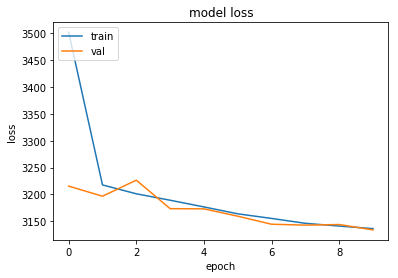

In [21]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # summarize history for loss
    plt.plot(train_result.history['loss'])
    plt.plot(train_result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [10]:
file_saved_flag = False

In [22]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # encoder from learned model
    encoder = Model(x, mean_lat)

    # generator / decoder from learned model
    _dec_ip = Input(shape=(lat_space_dimension,))
    _decFirst = decoder_first_layer(_dec_ip)
    _decFirstUp = decoder_first_upsample(_decFirst)
    _res = reshaper(_decFirstUp)
    _dc1_decoder = dc1(_res)
    _dc2_decoder = dc2(_dc1_decoder)
    _decSecondUp = decoder_second_upsample(_dc2_decoder)
    _decoder_mean = dcMean(_decSecondUp)
    generator = Model(_dec_ip, _decoder_mean)
    
    # Save trained models
    var_autoencoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    encoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    generator.save('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    
    # save train result
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'wb') as file_pi:
        cPickle.dump(train_result.history, file_pi)
    
    file_saved_flag = True

In [11]:
if not file_saved_flag and os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # load saved models
    var_autoencoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    encoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    generator = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})

    # load history if saved
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'rb') as fo:
        train_result = cPickle.load(fo)

C:\Users\sagar\Anaconda2\envs\py36\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


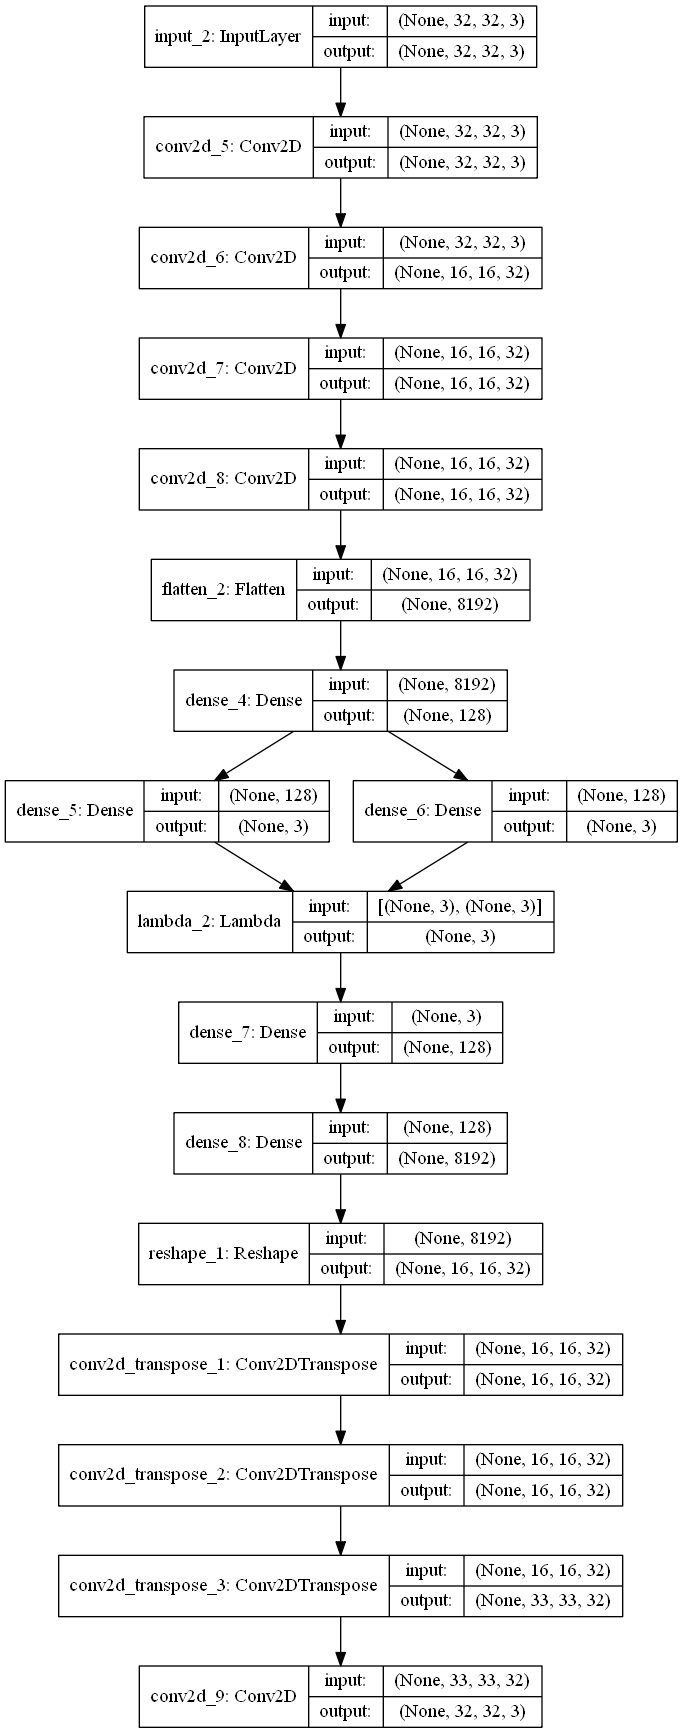

In [12]:
plot_model(var_autoencoder,show_shapes=True, to_file='./visualizations/vae1.png')
Image(filename='./visualizations/vae1.png')

In [13]:
encoded_test = encoder.predict(testX, batch_size=batch_size)

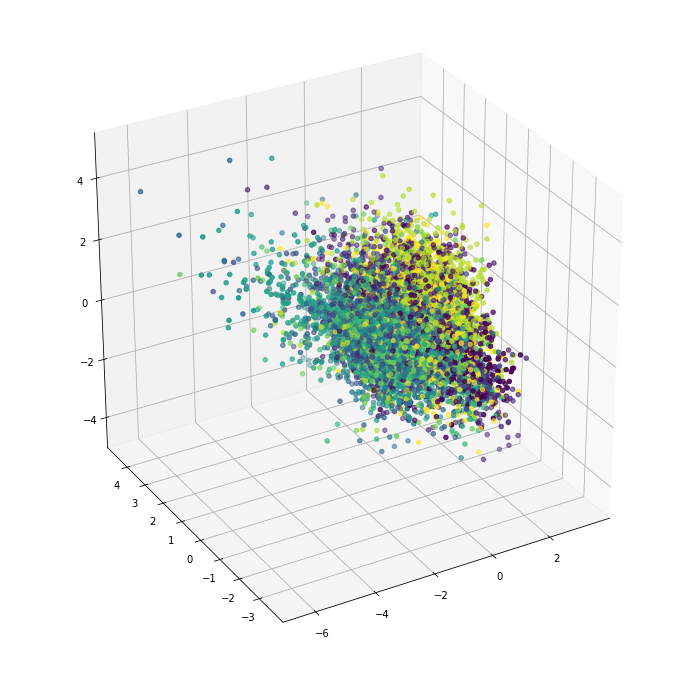

In [14]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 240)
ax.scatter(encoded_test[:, 0], encoded_test[:, 1],encoded_test[:, 2], c=testY)
plt.show()

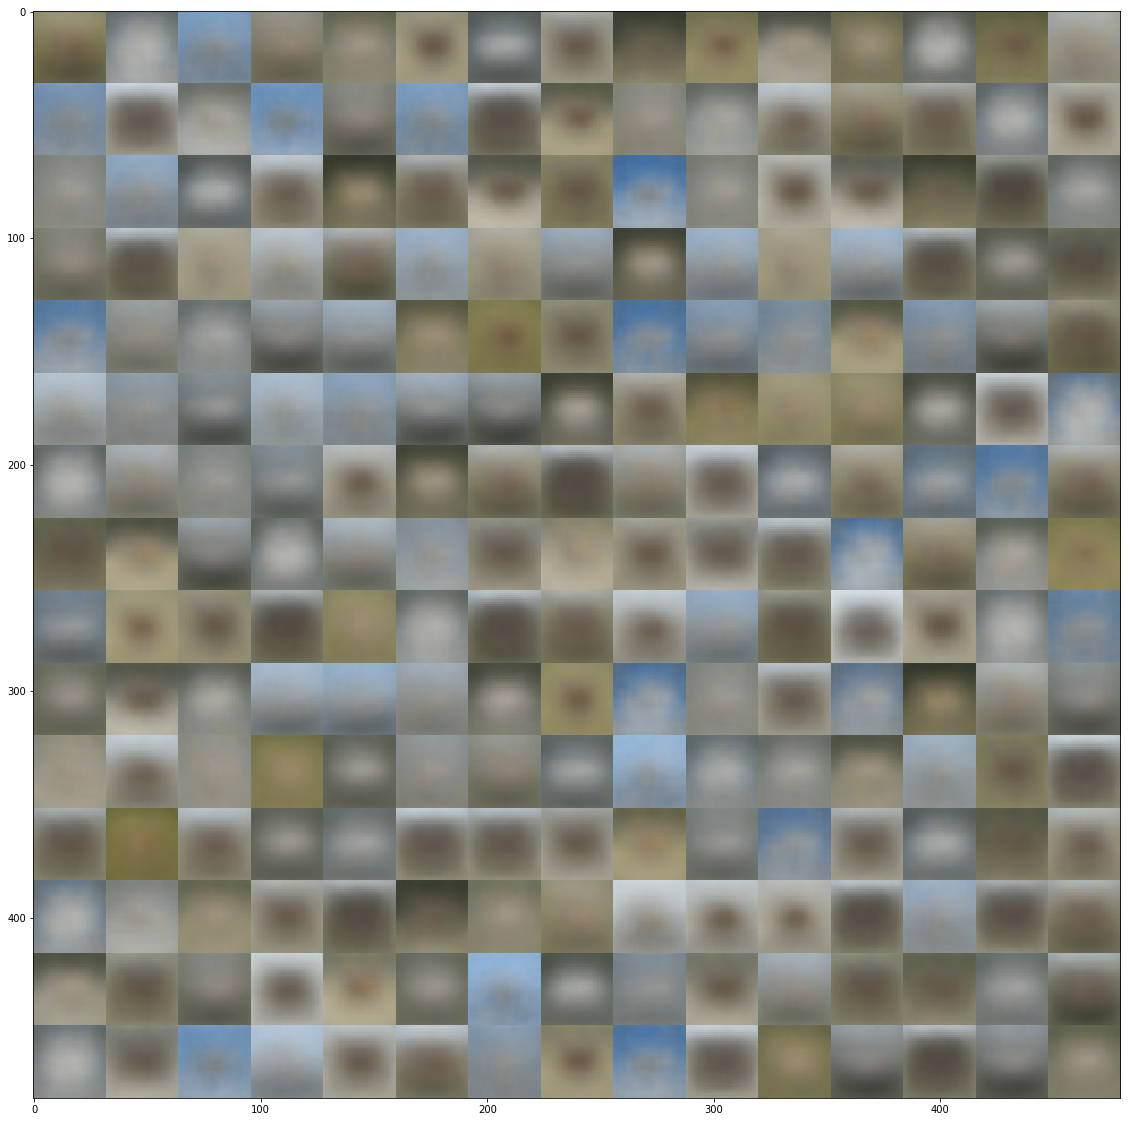

In [15]:
n = 15
figure = np.zeros((r * n, r * n, chnl))

for i in range(n):
    for j in range(n):
        sampled = np.array([np.random.uniform(-1,1 ,size=lat_space_dimension)])
        decoded = generator.predict(sampled)
        img = decoded[0].reshape(r, r, chnl)
        figure[i * r: (i + 1) * r,j * r: (j + 1) * r] = img
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

These generated images are very blurry. This may be because of the loss function that we are using [5] but first we will try working with other hyperparameters.

===============================================================================================================================

### Experiment 2
#### latent space dimension = 10, decoder input (intermediate dimension) shape = 512, rest same as experiment 1

In [9]:
decoder_input_shape = 512
lat_space_dimension = 10

# encoder
x = Input(shape=inputShape)
c1 = Conv2D(chnl,kernel_size=(2, 2),padding='same', activation='relu')(x)
c2 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(c1)
c3 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c2)
c4 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c3)
flat = Flatten()(c4)
encoder_last_layer = Dense(decoder_input_shape, activation='relu')(flat)

# mean and variance in latent representation
mean_lat = Dense(lat_space_dimension)(encoder_last_layer)
var_lat = Dense(lat_space_dimension)(encoder_last_layer)
z = Lambda(sampling_layer, output_shape=(lat_space_dimension,))([mean_lat, var_lat])

In [19]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 

    # decoder architecture
    decoder_first_layer = Dense(decoder_input_shape, activation='relu')
    decoder_first_upsample = Dense(int(filters * r / 2 * c / 2), activation='relu')
    reshaper = Reshape(outputShape[1:])
    dc1 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    dc2 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    decoder_second_upsample = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2),padding='valid',activation='relu')
    dcMean = Conv2D(chnl,kernel_size=2,padding='valid',activation='sigmoid')
    decFirst = decoder_first_layer(z)
    decFirstUp = decoder_first_upsample(decFirst)
    res = reshaper(decFirstUp)
    dc1_decoder = dc1(res)
    dc2_decoder = dc2(dc1_decoder)
    decSecondUp = decoder_second_upsample(dc2_decoder)
    decoder_mean = dcMean(decSecondUp)
    
    # entire model
    var_autoencoder = Model(x, decoder_mean)
    var_autoencoder.compile(optimizer='Adam', loss=custom_loss_function)
    train_result = var_autoencoder.fit(trainX,trainX,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(testX, testX))


In [20]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # summarize history for loss
    plt.plot(train_result.history['loss'])
    plt.plot(train_result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Here, the validation loss looks near to converge but the training loss has not converged. We can increase the number of epochs  in next experiments.

But this experiment has a lot lesser loss values compared to the previous one.

In [17]:
file_saved_flag = False

In [30]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # encoder from learned model
    encoder = Model(x, mean_lat)

    # generator / decoder from learned model
    _dec_ip = Input(shape=(lat_space_dimension,))
    _decFirst = decoder_first_layer(_dec_ip)
    _decFirstUp = decoder_first_upsample(_decFirst)
    _res = reshaper(_decFirstUp)
    _dc1_decoder = dc1(_res)
    _dc2_decoder = dc2(_dc1_decoder)
    _decSecondUp = decoder_second_upsample(_dc2_decoder)
    _decoder_mean = dcMean(_decSecondUp)
    generator = Model(_dec_ip, _decoder_mean)
    
    # Save trained models
    var_autoencoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    encoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    generator.save('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    
    # save train result
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'wb') as file_pi:
        cPickle.dump(train_result.history, file_pi)
    
    file_saved_flag = True

In [18]:
if not file_saved_flag and os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # load saved models
    var_autoencoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    encoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    generator = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})

    # load history if saved
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'rb') as fo:
        train_result = cPickle.load(fo)

C:\Users\sagar\Anaconda2\envs\py36\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


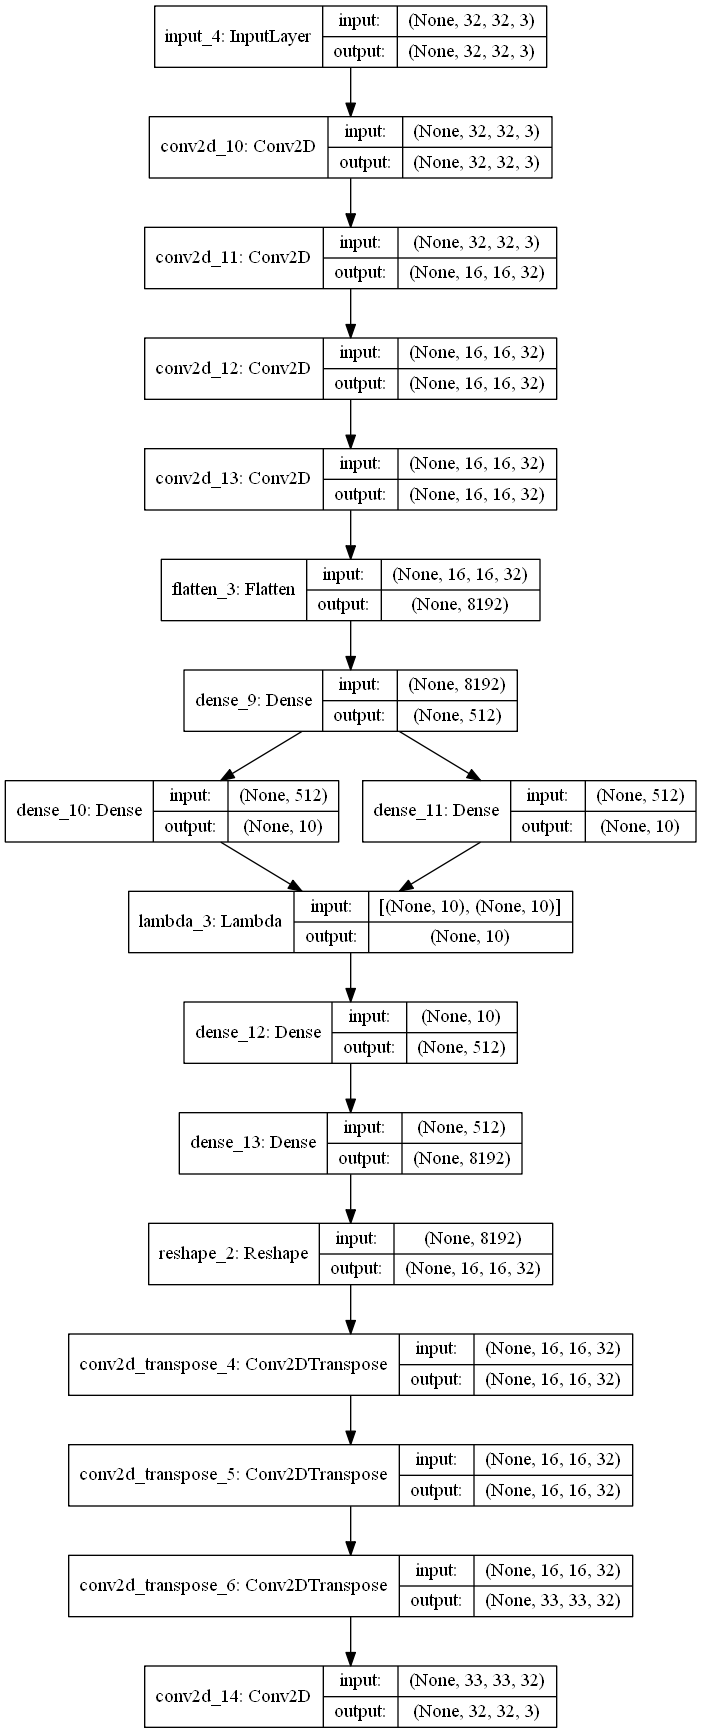

In [19]:
plot_model(var_autoencoder,show_shapes=True, to_file='./visualizations/vae2.png')
Image(filename='./visualizations/vae2.png')

In [20]:
encoded_test = encoder.predict(testX, batch_size=batch_size)

Since the latent space is 10 dimensional, we will use t-SNE to visualize it.

In [21]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_tsne' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(encoded_test)
    with open('./models/ld_%d_conv_%d_id_%d_e_%d_tsne' % (lat_space_dimension, convCount, decoder_input_shape, epochs), 'wb') as file_pi:
        cPickle.dump(X_tsne, file_pi)
else:
    with open('./models/ld_%d_conv_%d_id_%d_e_%d_tsne' % (lat_space_dimension, convCount, decoder_input_shape, epochs), 'rb') as fo:
        X_tsne = cPickle.load(fo)

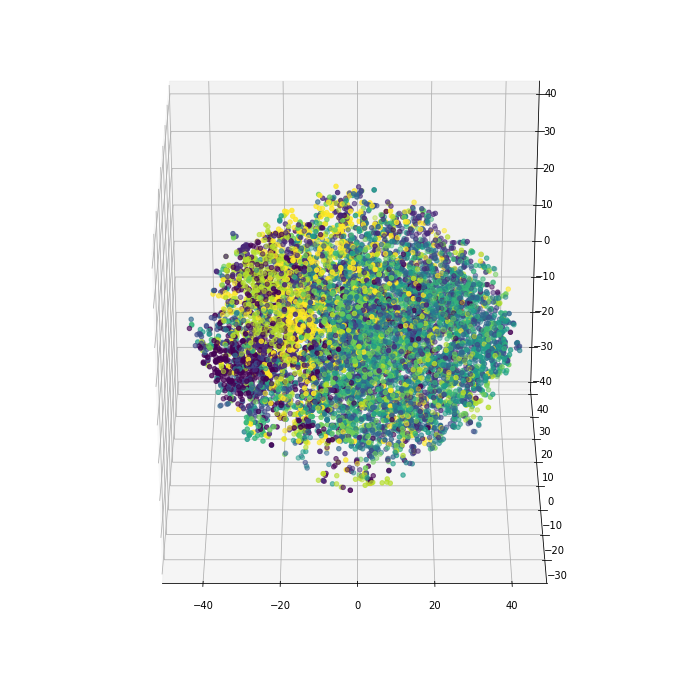

In [22]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 270)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],X_tsne[:, 2], c=testY)
plt.show()

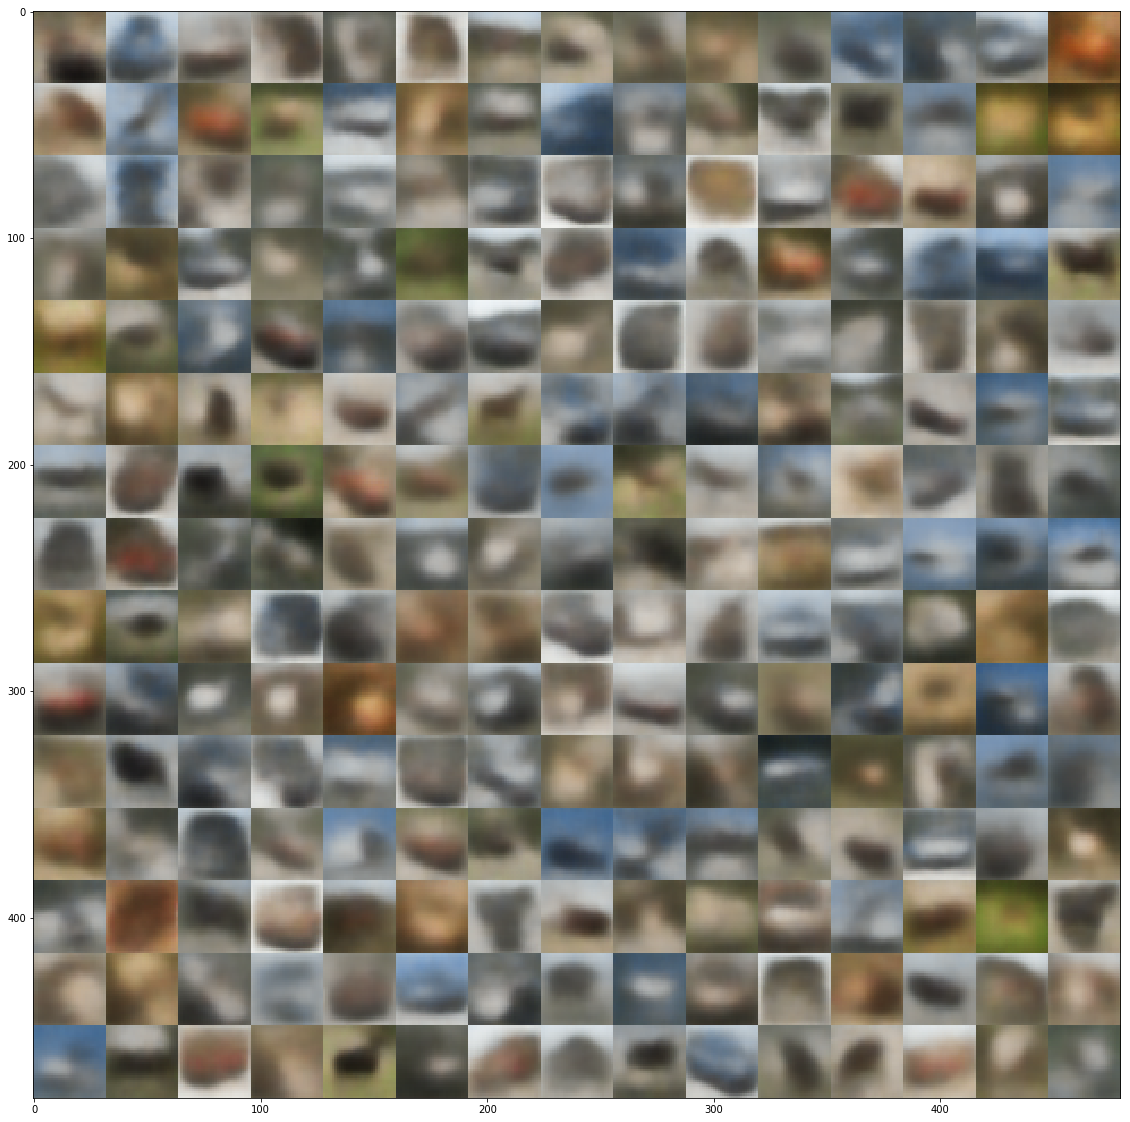

In [23]:
n = 15
figure = np.zeros((r * n, r * n, chnl))

for i in range(n):
    for j in range(n):
        sampled = np.array([np.random.uniform(-1,1 ,size=lat_space_dimension)])
        decoded = generator.predict(sampled)
        img = decoded[0].reshape(r, r, chnl)
        figure[i * r: (i + 1) * r,j * r: (j + 1) * r] = img
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

So the generator is giving slightly better results than the previous experiment now. So we'll freeze the latent dimension=10, intermediate dimension=512.

We wanted to add an additional dropout layer for regularization. Reference [9] mentions that "adding dropout to the latent variable z increases the number of active units (Fig. 3), but it generalizes poorly as it uses the dropout layers to merely replicate representation. This results in blurriness in both generation and reconstruction. But it is still better than the standard VAE." 

In our case, we tried with multiple dropout combinations (1 dropout layer =0.5 after z, dropout=0.5 after biggest dense layers in both encoder and decoder) but it resulted in higher validation loss while training so we stopped with it and did not experiment further.

In following experiment, we ran only 5 epochs with dropout on sampling layer as mentioned in [9]. It gives higher val loss for respective epochs while compared to the experiments with no Dropout.

===============================================================================================================================

### Experiment 3
#### epochs = 5, added dropout after sampling layer, rest same as experiment 2

In [47]:
epochs = 5

# encoder
x = Input(shape=inputShape)
c1 = Conv2D(chnl,kernel_size=(2, 2),padding='same', activation='relu')(x)
c2 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(c1)
c3 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c2)
c4 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c3)
flat = Flatten()(c4)
encoder_last_layer = Dense(decoder_input_shape, activation='relu')(flat)

# mean and variance in latent representation
mean_lat = Dense(lat_space_dimension)(encoder_last_layer)
var_lat = Dense(lat_space_dimension)(encoder_last_layer)
z = Lambda(sampling_layer, output_shape=(lat_space_dimension,))([mean_lat, var_lat])
dropout = Dropout(0.5)
d1 = dropout(z)

# decoder architecture
decoder_first_layer = Dense(decoder_input_shape, activation='relu')
decoder_first_upsample = Dense(int(filters * r / 2 * c / 2), activation='relu')
reshaper = Reshape(outputShape[1:])
dc1 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
dc2 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
decoder_second_upsample = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2),padding='valid',activation='relu')
dcMean = Conv2D(chnl,kernel_size=2,padding='valid',activation='sigmoid')
decFirst = decoder_first_layer(d1)
decFirstUp = decoder_first_upsample(decFirst)
res = reshaper(decFirstUp)
dc1_decoder = dc1(res)
dc2_decoder = dc2(dc1_decoder)
decSecondUp = decoder_second_upsample(dc2_decoder)
decoder_mean = dcMean(decSecondUp)

# entire model
var_autoencoder = Model(x, decoder_mean)
var_autoencoder.compile(optimizer='Adam', loss=custom_loss_function)
train_result = var_autoencoder.fit(trainX,trainX,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(testX, testX))


Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 113s 2ms/step - loss: 3923.4490 - val_loss: 3690.8358
Epoch 2/5
50000/50000 [==============================] - 110s 2ms/step - loss: 3469.1002 - val_loss: 3563.9934
Epoch 3/5
50000/50000 [==============================] - 110s 2ms/step - loss: 3398.9317 - val_loss: 3365.3963
Epoch 4/5
50000/50000 [==============================] - 112s 2ms/step - loss: 3350.6730 - val_loss: 3461.1446
Epoch 5/5
50000/50000 [==============================] - 111s 2ms/step - loss: 3324.8390 - val_loss: 3344.7763


Now we'll train the model of experiment 2 for 100 epochs and observe the loss. 


===============================================================================================================================

### Experiment 4
#### epochs = 100, rest same as experiment 2

In [10]:
epochs = 100

# encoder
x = Input(shape=inputShape)
c1 = Conv2D(chnl,kernel_size=(2, 2),padding='same', activation='relu')(x)
c2 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(c1)
c3 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c2)
c4 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c3)
flat = Flatten()(c4)
encoder_last_layer = Dense(decoder_input_shape, activation='relu')(flat)

# mean and variance in latent representation
mean_lat = Dense(lat_space_dimension)(encoder_last_layer)
var_lat = Dense(lat_space_dimension)(encoder_last_layer)
z = Lambda(sampling_layer, output_shape=(lat_space_dimension,))([mean_lat, var_lat])

In [51]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 

    # decoder architecture
    decoder_first_layer = Dense(decoder_input_shape, activation='relu')
    decoder_first_upsample = Dense(int(filters * r / 2 * c / 2), activation='relu')
    reshaper = Reshape(outputShape[1:])
    dc1 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    dc2 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    decoder_second_upsample = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2),padding='valid',activation='relu')
    dcMean = Conv2D(chnl,kernel_size=2,padding='valid',activation='sigmoid')
    decFirst = decoder_first_layer(z)
    decFirstUp = decoder_first_upsample(decFirst)
    res = reshaper(decFirstUp)
    dc1_decoder = dc1(res)
    dc2_decoder = dc2(dc1_decoder)
    decSecondUp = decoder_second_upsample(dc2_decoder)
    decoder_mean = dcMean(decSecondUp)
    
    # entire model
    var_autoencoder = Model(x, decoder_mean)
    var_autoencoder.compile(optimizer='Adam', loss=custom_loss_function)
    train_result = var_autoencoder.fit(trainX,trainX,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(testX, testX))


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 115s 2ms/step - loss: 2591.3680 - val_loss: 2107.3637
Epoch 2/100
50000/50000 [==============================] - 111s 2ms/step - loss: 2061.3564 - val_loss: 2047.9617
Epoch 3/100
50000/50000 [==============================] - 112s 2ms/step - loss: 2026.8833 - val_loss: 2037.1635
Epoch 4/100
50000/50000 [==============================] - 112s 2ms/step - loss: 2004.4082 - val_loss: 2021.0187
Epoch 5/100
50000/50000 [==============================] - 112s 2ms/step - loss: 1983.8561 - val_loss: 2016.3493
Epoch 6/100
50000/50000 [==============================] - 112s 2ms/step - loss: 1967.6441 - val_loss: 1994.2203
Epoch 7/100
50000/50000 [==============================] - 112s 2ms/step - loss: 1953.4495 - val_loss: 2008.9980
Epoch 8/100
50000/50000 [==============================] - 112s 2ms/step - loss: 1940.5360 - val_loss: 1990.7109
Epoch 9/100
50000/50000 [=====================

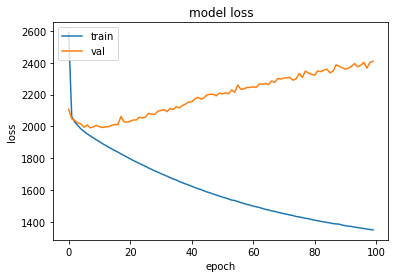

In [52]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # summarize history for loss
    plt.plot(train_result.history['loss'])
    plt.plot(train_result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

#### As we can see, the val loss starts increasing i.e the model starts overfitting after ~15 epochs. So for now, we'll freeze the epoch count to 15.

In [25]:
file_saved_flag = False

In [54]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # encoder from learned model
    encoder = Model(x, mean_lat)

    # generator / decoder from learned model
    _dec_ip = Input(shape=(lat_space_dimension,))
    _decFirst = decoder_first_layer(_dec_ip)
    _decFirstUp = decoder_first_upsample(_decFirst)
    _res = reshaper(_decFirstUp)
    _dc1_decoder = dc1(_res)
    _dc2_decoder = dc2(_dc1_decoder)
    _decSecondUp = decoder_second_upsample(_dc2_decoder)
    _decoder_mean = dcMean(_decSecondUp)
    generator = Model(_dec_ip, _decoder_mean)
    
    # Save trained models
    var_autoencoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    encoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    generator.save('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    
    # save train result
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'wb') as file_pi:
        cPickle.dump(train_result.history, file_pi)
    
    file_saved_flag = True

In [26]:
if not file_saved_flag and os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # load saved models
    var_autoencoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    encoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    generator = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})

    # load history if saved
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'rb') as fo:
        train_result = cPickle.load(fo)

C:\Users\sagar\Anaconda2\envs\py36\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [27]:
encoded_test = encoder.predict(testX, batch_size=batch_size)

In [28]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_tsne' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(encoded_test)
    with open('./models/ld_%d_conv_%d_id_%d_e_%d_tsne' % (lat_space_dimension, convCount, decoder_input_shape, epochs), 'wb') as file_pi:
        cPickle.dump(X_tsne, file_pi)
else:
    with open('./models/ld_%d_conv_%d_id_%d_e_%d_tsne' % (lat_space_dimension, convCount, decoder_input_shape, epochs), 'rb') as fo:
        X_tsne = cPickle.load(fo)

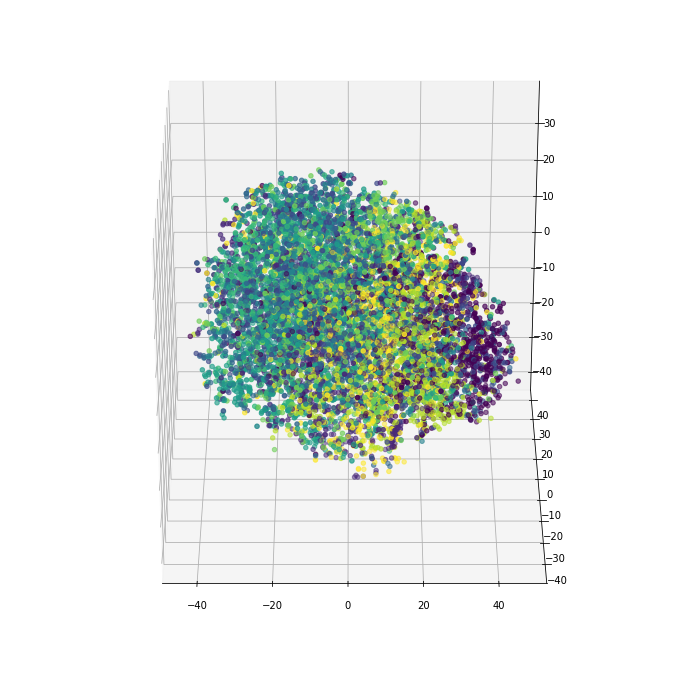

In [29]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 270)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],X_tsne[:, 2], c=testY)
plt.show()

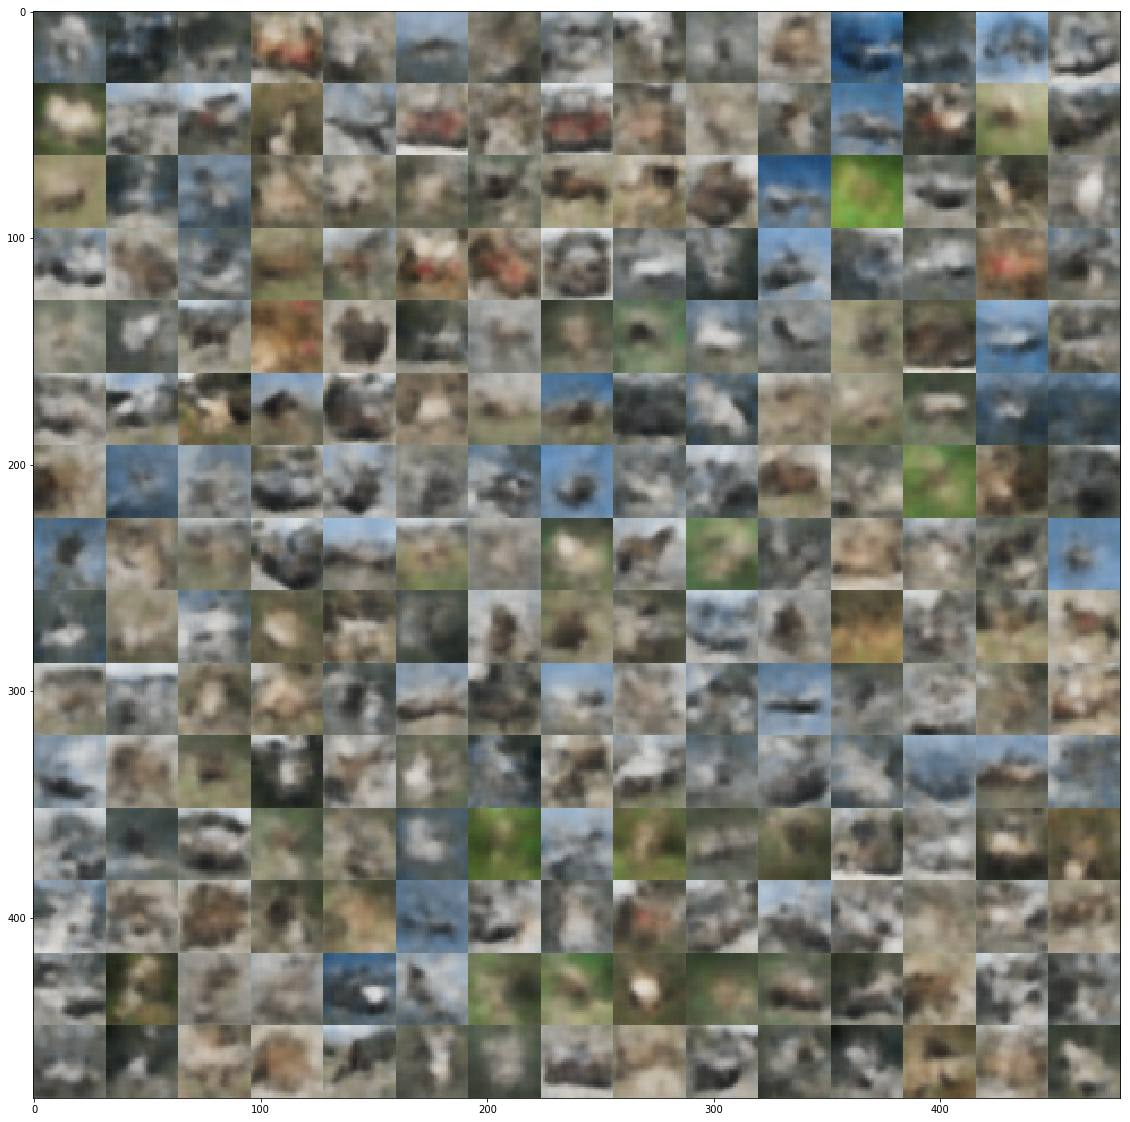

In [30]:
n = 15
figure = np.zeros((r * n, r * n, chnl))

for i in range(n):
    for j in range(n):
        sampled = np.array([np.random.uniform(-1,1 ,size=lat_space_dimension)])
        decoded = generator.predict(sampled)
        img = decoded[0].reshape(r, r, chnl)
        figure[i * r: (i + 1) * r,j * r: (j + 1) * r] = img
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Now this generation is better than before, specially shapes and colors, but still it is very blurry. We learn that the model starts overfitting after 15 epochs so we'll keep epochs=15.  Now we'll experiment with another loss function.

===============================================================================================================================

### Experiment 5
#### epochs = 15, loss = binary cross entropy generation loss, rest same as experiment 4

In [11]:
epochs = 15

# encoder
x = Input(shape=inputShape)
c1 = Conv2D(chnl,kernel_size=(2, 2),padding='same', activation='relu')(x)
c2 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(c1)
c3 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c2)
c4 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c3)
flat = Flatten()(c4)
encoder_last_layer = Dense(decoder_input_shape, activation='relu')(flat)

# mean and variance in latent representation
mean_lat = Dense(lat_space_dimension)(encoder_last_layer)
var_lat = Dense(lat_space_dimension)(encoder_last_layer)
z = Lambda(sampling_layer, output_shape=(lat_space_dimension,))([mean_lat, var_lat])

In [35]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 

    # decoder architecture
    decoder_first_layer = Dense(decoder_input_shape, activation='relu')
    decoder_first_upsample = Dense(int(filters * r / 2 * c / 2), activation='relu')
    reshaper = Reshape(outputShape[1:])
    dc1 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    dc2 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    decoder_second_upsample = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2),padding='valid',activation='relu')
    dcMean = Conv2D(chnl,kernel_size=2,padding='valid',activation='sigmoid')
    decFirst = decoder_first_layer(z)
    decFirstUp = decoder_first_upsample(decFirst)
    res = reshaper(decFirstUp)
    dc1_decoder = dc1(res)
    dc2_decoder = dc2(dc1_decoder)
    decSecondUp = decoder_second_upsample(dc2_decoder)
    decoder_mean = dcMean(decSecondUp)
    
    # entire model
    var_autoencoder = Model(x, decoder_mean)
    var_autoencoder.compile(optimizer='Adam', loss=cross_entropy_loss_function)
    train_result = var_autoencoder.fit(trainX,trainX,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(testX, testX))


Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 116s 2ms/step - loss: 636.0755 - val_loss: 627.0019
Epoch 2/15
50000/50000 [==============================] - 111s 2ms/step - loss: 623.5504 - val_loss: 623.7527
Epoch 3/15
50000/50000 [==============================] - 112s 2ms/step - loss: 622.4270 - val_loss: 623.5235
Epoch 4/15
50000/50000 [==============================] - 112s 2ms/step - loss: 621.8958 - val_loss: 622.8302
Epoch 5/15
50000/50000 [==============================] - 112s 2ms/step - loss: 621.5548 - val_loss: 622.4071
Epoch 6/15
50000/50000 [==============================] - 111s 2ms/step - loss: 621.2505 - val_loss: 622.3260
Epoch 7/15
50000/50000 [==============================] - 111s 2ms/step - loss: 620.9681 - val_loss: 622.3077
Epoch 8/15
50000/50000 [==============================] - 112s 2ms/step - loss: 620.6840 - val_loss: 622.3087
Epoch 9/15
50000/50000 [==============================] - 112s 2ms/ste

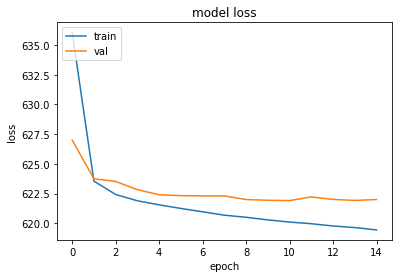

In [36]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # summarize history for loss
    plt.plot(train_result.history['loss'])
    plt.plot(train_result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [12]:
file_saved_flag = False

In [38]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # encoder from learned model
    encoder = Model(x, mean_lat)

    # generator / decoder from learned model
    _dec_ip = Input(shape=(lat_space_dimension,))
    _decFirst = decoder_first_layer(_dec_ip)
    _decFirstUp = decoder_first_upsample(_decFirst)
    _res = reshaper(_decFirstUp)
    _dc1_decoder = dc1(_res)
    _dc2_decoder = dc2(_dc1_decoder)
    _decSecondUp = decoder_second_upsample(_dc2_decoder)
    _decoder_mean = dcMean(_decSecondUp)
    generator = Model(_dec_ip, _decoder_mean)
    
    # Save trained models
    var_autoencoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    encoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    generator.save('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    
    # save train result
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'wb') as file_pi:
        cPickle.dump(train_result.history, file_pi)
    
    file_saved_flag = True

In [ ]:
if not file_saved_flag and os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # load saved models
    var_autoencoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    encoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    generator = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})

    # load history if saved
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'rb') as fo:
        train_result = cPickle.load(fo)

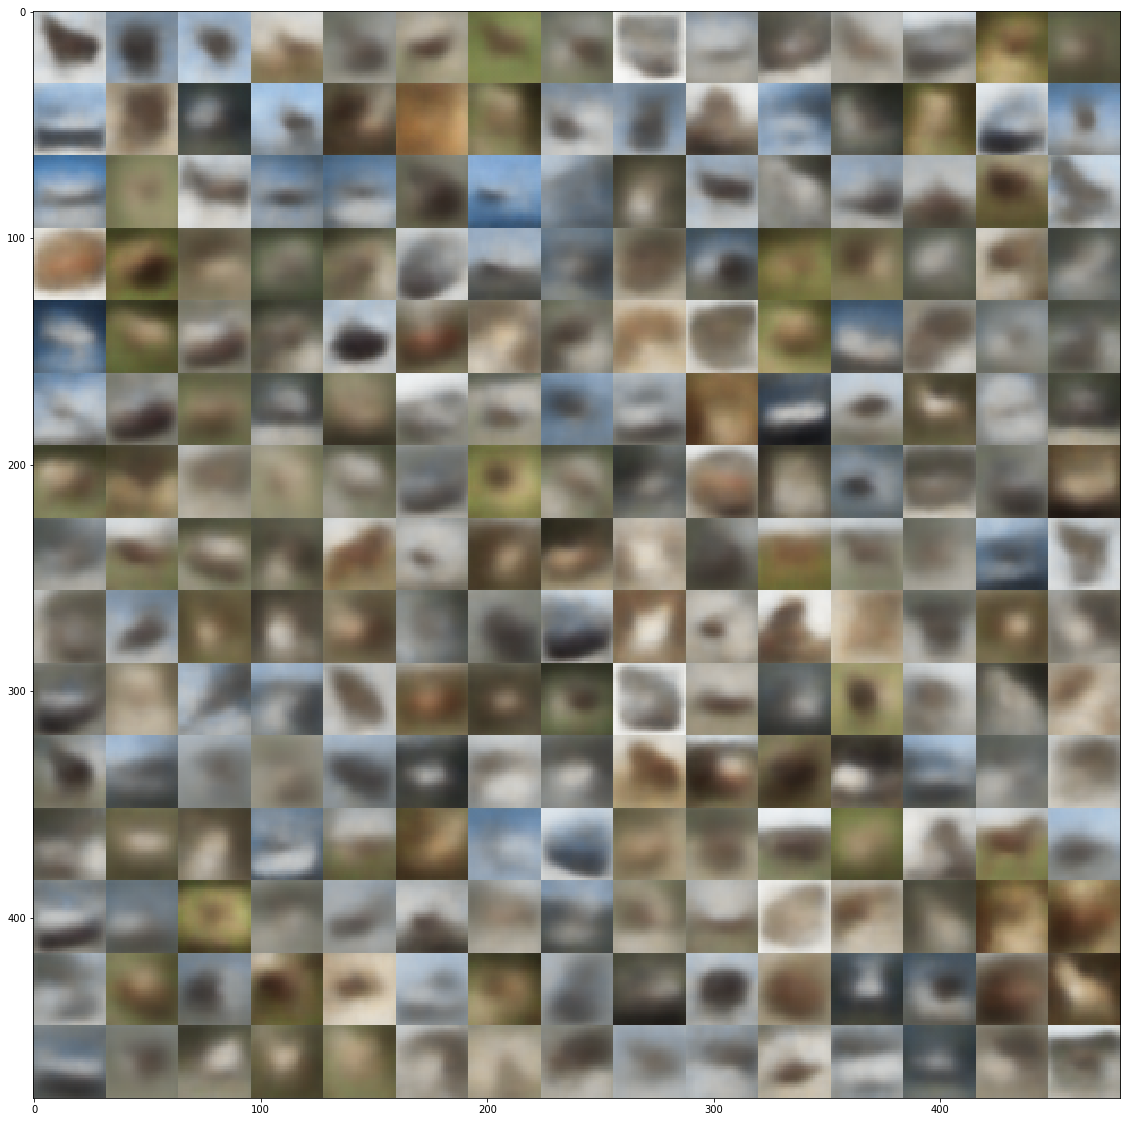

In [34]:
n = 15
figure = np.zeros((r * n, r * n, chnl))

for i in range(n):
    for j in range(n):
        sampled = np.array([np.random.uniform(-1,1 ,size=lat_space_dimension)])
        decoded = generator.predict(sampled)
        img = decoded[0].reshape(r, r, chnl)
        figure[i * r: (i + 1) * r,j * r: (j + 1) * r] = img
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

As we can see here, the binary cross entropy loss does not perform better than L2 loss. So we'll stick to the L2 generation loss for now. 

### L2 Loss function with feature space loss. 

Now as explained in [3], we will add a feature space loss to our custom L2 loss function i.e. the Euclidean distance in feature space. We will use VGG16 to extract features from the original and the reconstructed images and then the euclidean distance between both vectors is added to the loss function.

We also wanted to add the adversarial loss like explained in [3], but we could not due to time crunch.

===============================================================================================================================

### Experiment 6
#### epoch=11, loss = L2 with feature space loss, rest same as experiment 5

In [35]:
def L2_feature_space_loss_function(x, decoder_mean):
    
    vgg_x = x
    for layer in vgg.layers:
        vgg_x = layer(vgg_x)
    
    vgg_decoder_mean = decoder_mean
    for layer in vgg.layers:
        vgg_decoder_mean = layer(vgg_decoder_mean)
    
    
    x = K.flatten(x)
    decoder_mean = K.flatten(decoder_mean)
    vgg_x = K.flatten(vgg_x)
    vgg_decoder_mean = K.flatten(vgg_decoder_mean)

    gen_loss = K.sum(K.square(decoder_mean-x))
    kl_divergence = - 0.5 * K.sum(1 + var_lat - K.square(mean_lat) - K.square(K.exp(var_lat)), axis=-1)
    
    feature_space_loss = K.sum(K.square(vgg_decoder_mean-vgg_x))

    return K.mean(gen_loss + kl_divergence+feature_space_loss)


keras.losses.L2_feature_space_loss_function = L2_feature_space_loss_function

*** We implemented the custom loss function as a layer initially (in the cell below) but it is not working because of limitations in the keras library. It is not able to register the loss layer implemented in the cell below. Following issues on Keras github highlight this -
- https://github.com/keras-team/keras/issues/2488
- https://github.com/keras-team/keras/issues/2121
- https://github.com/keras-team/keras/issues/6373
- 

In [36]:
# # L2 with feature space loss layer
# class L2_feature_space_loss_function(Layer):
#     def __init__(self, **kwargs):
#         self.is_placeholder = True
#         super(L2_feature_space_loss_function, self).__init__(**kwargs)

#     def L2_feature_space_loss(self, x, decoder_mean, vgg_x, vgg_decoder_mean):
#         x = K.flatten(x)
#         decoder_mean = K.flatten(decoder_mean)
#         vgg_x = K.flatten(vgg_x)
#         vgg_decoder_mean = K.flatten(vgg_decoder_mean)
        
#         gen_loss = K.sum(K.square(decoder_mean-x))
#         kl_divergence = - 0.5 * K.sum(1 + var_lat - K.square(mean_lat) - K.square(K.exp(var_lat)), axis=-1)
#         feature_space_loss = K.sum(K.square(vgg_decoder_mean-vgg_x))
        
#         return K.mean(gen_loss + kl_divergence+feature_space_loss)

#     def call(self, inputs):
#         loss = self.L2_feature_space_loss(inputs[0], inputs[1], inputs[2], inputs[3])
#         self.add_loss(loss, inputs=inputs)
#         return x

# keras.losses.L2_feature_space_loss_function = L2_feature_space_loss_function

In [13]:
epochs = 11

# encoder
x = Input(shape=inputShape)
c1 = Conv2D(chnl,kernel_size=(2, 2),padding='same', activation='relu')(x)
c2 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(c1)
c3 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c2)
c4 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(c3)
flat = Flatten()(c4)
encoder_last_layer = Dense(decoder_input_shape, activation='relu')(flat)

# mean and variance in latent representation
mean_lat = Dense(lat_space_dimension)(encoder_last_layer)
var_lat = Dense(lat_space_dimension)(encoder_last_layer)
z = Lambda(sampling_layer, output_shape=(lat_space_dimension,))([mean_lat, var_lat])

In [38]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 

    # decoder architecture
    decoder_first_layer = Dense(decoder_input_shape, activation='relu')
    decoder_first_upsample = Dense(int(filters * r / 2 * c / 2), activation='relu')
    reshaper = Reshape(outputShape[1:])
    dc1 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    dc2 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    decoder_second_upsample = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2),padding='valid',activation='relu')
    dcMean = Conv2D(chnl,kernel_size=2,padding='valid',activation='sigmoid')
    decFirst = decoder_first_layer(z)
    decFirstUp = decoder_first_upsample(decFirst)
    res = reshaper(decFirstUp)
    dc1_decoder = dc1(res)
    dc2_decoder = dc2(dc1_decoder)
    decSecondUp = decoder_second_upsample(dc2_decoder)
    decoder_mean = dcMean(decSecondUp)
    
    #y = L2_feature_space_loss_function()([x, decoder_mean, vgg_x, vgg_decoder_mean])

    # entire model
    var_autoencoder = Model(x, decoder_mean)
    var_autoencoder.compile(optimizer='Adam', loss=L2_feature_space_loss_function)
    #var_autoencoder.summary()
    train_result = var_autoencoder.fit(trainX,trainX,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(testX, testX))


Train on 50000 samples, validate on 10000 samples
Epoch 1/11
50000/50000 [==============================] - 374s 7ms/step - loss: 3818.2368 - val_loss: 3377.8235
Epoch 2/11
50000/50000 [==============================] - 370s 7ms/step - loss: 3259.6508 - val_loss: 3208.5895
Epoch 3/11
50000/50000 [==============================] - 370s 7ms/step - loss: 3161.9162 - val_loss: 3165.1572
Epoch 4/11
50000/50000 [==============================] - 370s 7ms/step - loss: 3113.7495 - val_loss: 3129.2696
Epoch 5/11
50000/50000 [==============================] - 370s 7ms/step - loss: 3078.9359 - val_loss: 3099.9088
Epoch 6/11
50000/50000 [==============================] - 370s 7ms/step - loss: 3048.9287 - val_loss: 3153.3545
Epoch 7/11
50000/50000 [==============================] - 370s 7ms/step - loss: 3021.2204 - val_loss: 3097.8157
Epoch 8/11
50000/50000 [==============================] - 370s 7ms/step - loss: 2995.7046 - val_loss: 3079.0965
Epoch 9/11
50000/50000 [==============================

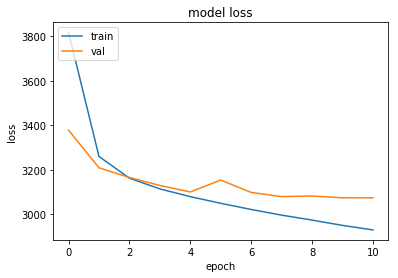

In [39]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # summarize history for loss
    plt.plot(train_result.history['loss'])
    plt.plot(train_result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [40]:
file_saved_flag = False

In [41]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # encoder from learned model
    encoder = Model(x, mean_lat)

    # generator / decoder from learned model
    _dec_ip = Input(shape=(lat_space_dimension,))
    _decFirst = decoder_first_layer(_dec_ip)
    _decFirstUp = decoder_first_upsample(_decFirst)
    _res = reshaper(_decFirstUp)
    _dc1_decoder = dc1(_res)
    _dc2_decoder = dc2(_dc1_decoder)
    _decSecondUp = decoder_second_upsample(_dc2_decoder)
    _decoder_mean = dcMean(_decSecondUp)
    generator = Model(_dec_ip, _decoder_mean)
    
    # Save trained models
    var_autoencoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    encoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    generator.save('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    
    # save train result
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'wb') as file_pi:
        cPickle.dump(train_result.history, file_pi)
    
    file_saved_flag = True

In [42]:
if not file_saved_flag and os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # load saved models
    var_autoencoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    encoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    generator = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})

    # load history if saved
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'rb') as fo:
        train_result = cPickle.load(fo)

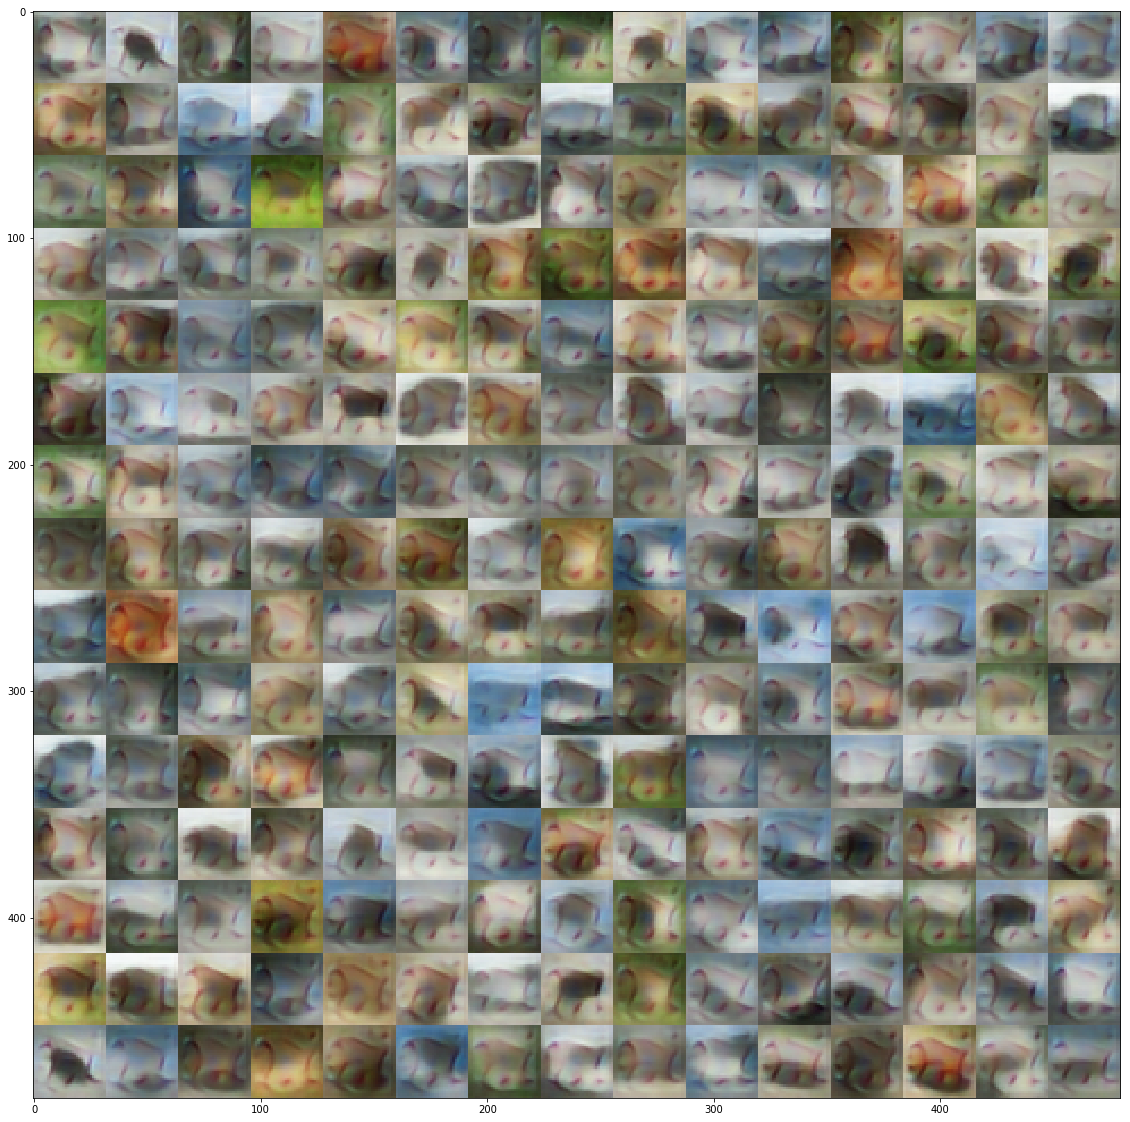

In [43]:
n = 15
figure = np.zeros((r * n, r * n, chnl))

for i in range(n):
    for j in range(n):
        sampled = np.array([np.random.uniform(-1,1 ,size=lat_space_dimension)])
        decoded = generator.predict(sampled)
        img = decoded[0].reshape(r, r, chnl)
        figure[i * r: (i + 1) * r,j * r: (j + 1) * r] = img
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Now when we involved the feature space loss with L2, the model seems to have learned a specific combination of shapes.

===============================================================================================================================

Now as explained in [10] - we will add batch normalization to our architecture.

This paper [10] proposes warming up of the weight units i.e. for some initial epochs only use the generation loss and not use KL divergence; We also wanted to add it but time did not allow us.

### Experiment 7
#### Batch Norm, batch size = 128, epochs=12, optimizer='rms_prop', loss=cross_entropy_loss_function, rest same as experiment 4

In [39]:
from keras.layers.normalization import BatchNormalization

batch_size = 128
epochs=12
outputShape = (batch_size, int(r / 2), int(c / 2), filters)

# encoder
x = Input(shape=inputShape)
xb = BatchNormalization()(x)


c1 = Conv2D(chnl,kernel_size=(2, 2),padding='same', activation='relu')(xb)
b1 = BatchNormalization()(c1)

c2 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(b1)
b2 = BatchNormalization()(c2)

c3 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(b2)
b3 = BatchNormalization()(c3)

c4 = Conv2D(filters,kernel_size=convCount,padding='same', activation='relu',strides=1)(b3)
b4 = BatchNormalization()(c4)


flat = Flatten()(b4)
encoder_last_layer = Dense(decoder_input_shape, activation='relu')(flat)

# mean and variance in latent representation
mean_lat = Dense(lat_space_dimension)(encoder_last_layer)
var_lat = Dense(lat_space_dimension)(encoder_last_layer)
z = Lambda(sampling_layer, output_shape=(lat_space_dimension,))([mean_lat, var_lat])

In [40]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 

    # decoder architecture
    decoder_first_layer = Dense(decoder_input_shape, activation='relu')
    decoder_first_upsample = Dense(int(filters * r / 2 * c / 2), activation='relu')
    reshaper = Reshape(outputShape[1:])
    dc1 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    dc2 = Conv2DTranspose(filters,kernel_size=convCount,padding='same',strides=1,activation='relu')
    decoder_second_upsample = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2),padding='valid',activation='relu')
    dcMean = Conv2D(chnl,kernel_size=2,padding='valid',activation='sigmoid')
    
    decFirst = decoder_first_layer(z)
    bd1 = BatchNormalization()(decFirst)
    
    decFirstUp = decoder_first_upsample(bd1)
    bd2 = BatchNormalization()(decFirstUp)
    
    res = reshaper(bd2)
    dc1_decoder = dc1(res)
    bd3 = BatchNormalization()(dc1_decoder)
    
    dc2_decoder = dc2(bd3)
    bd4 = BatchNormalization()(dc2_decoder)
    
    decSecondUp = decoder_second_upsample(bd4)
    bd5 = BatchNormalization()(decSecondUp)
    
    decoder_mean = dcMean(bd5)
    
    # entire model
    var_autoencoder = Model(x, decoder_mean)
    var_autoencoder.compile(optimizer='Adam', loss=cross_entropy_loss_function)
    #var_autoencoder.summary()
    train_result = var_autoencoder.fit(trainX,trainX,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(testX, testX))


Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 74s 1ms/step - loss: 4279993301202181816320.0000 - val_loss: 457481216.9328
Epoch 2/12
50000/50000 [==============================] - 68s 1ms/step - loss: 384494886807.8398 - val_loss: 49798.0014
Epoch 3/12
50000/50000 [==============================] - 67s 1ms/step - loss: 1004.4044 - val_loss: 57696.8951
Epoch 4/12
50000/50000 [==============================] - 67s 1ms/step - loss: 119206.6434 - val_loss: 51406.2823
Epoch 5/12
50000/50000 [==============================] - 66s 1ms/step - loss: 2109.3076 - val_loss: 40711.0319
Epoch 6/12
50000/50000 [==============================] - 67s 1ms/step - loss: 1853495.2194 - val_loss: 22226.2160
Epoch 7/12
50000/50000 [==============================] - 66s 1ms/step - loss: 714.4177 - val_loss: 65990.3303
Epoch 8/12
50000/50000 [==============================] - 67s 1ms/step - loss: 1106.2440 - val_loss: 37462.5620
Epoch 9/12
50000/500

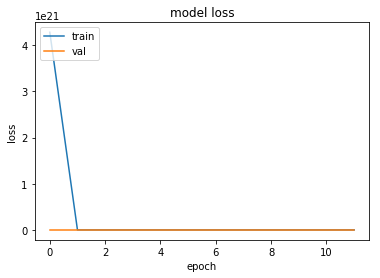

In [41]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # summarize history for loss
    plt.plot(train_result.history['loss'])
    plt.plot(train_result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [32]:
file_saved_flag = False

In [42]:
if not os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # encoder from learned model
    encoder = Model(x, mean_lat)

    # generator / decoder from learned model
    _dec_ip = Input(shape=(lat_space_dimension,))
    _decFirst = decoder_first_layer(_dec_ip)
    _decFirstUp = decoder_first_upsample(_decFirst)
    _res = reshaper(_decFirstUp)
    _dc1_decoder = dc1(_res)
    _dc2_decoder = dc2(_dc1_decoder)
    _decSecondUp = decoder_second_upsample(_dc2_decoder)
    _decoder_mean = dcMean(_decSecondUp)
    generator = Model(_dec_ip, _decoder_mean)
    
    # Save trained models
    var_autoencoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    encoder.save('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    generator.save('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs))
    
    # save train result
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'wb') as file_pi:
        cPickle.dump(train_result.history, file_pi)
    
    file_saved_flag = True

In [43]:
if not file_saved_flag and os.path.isfile('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs)): 
    # load saved models
    var_autoencoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    encoder = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})
    generator = keras.models.load_model('./models/ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (lat_space_dimension, convCount, decoder_input_shape, epochs),
        custom_objects={'lat_space_dimension':lat_space_dimension, 'eps':1.0})

    # load history if saved
    fname = './models/ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (lat_space_dimension, convCount, decoder_input_shape, epochs)
    with open(fname, 'rb') as fo:
        train_result = cPickle.load(fo)

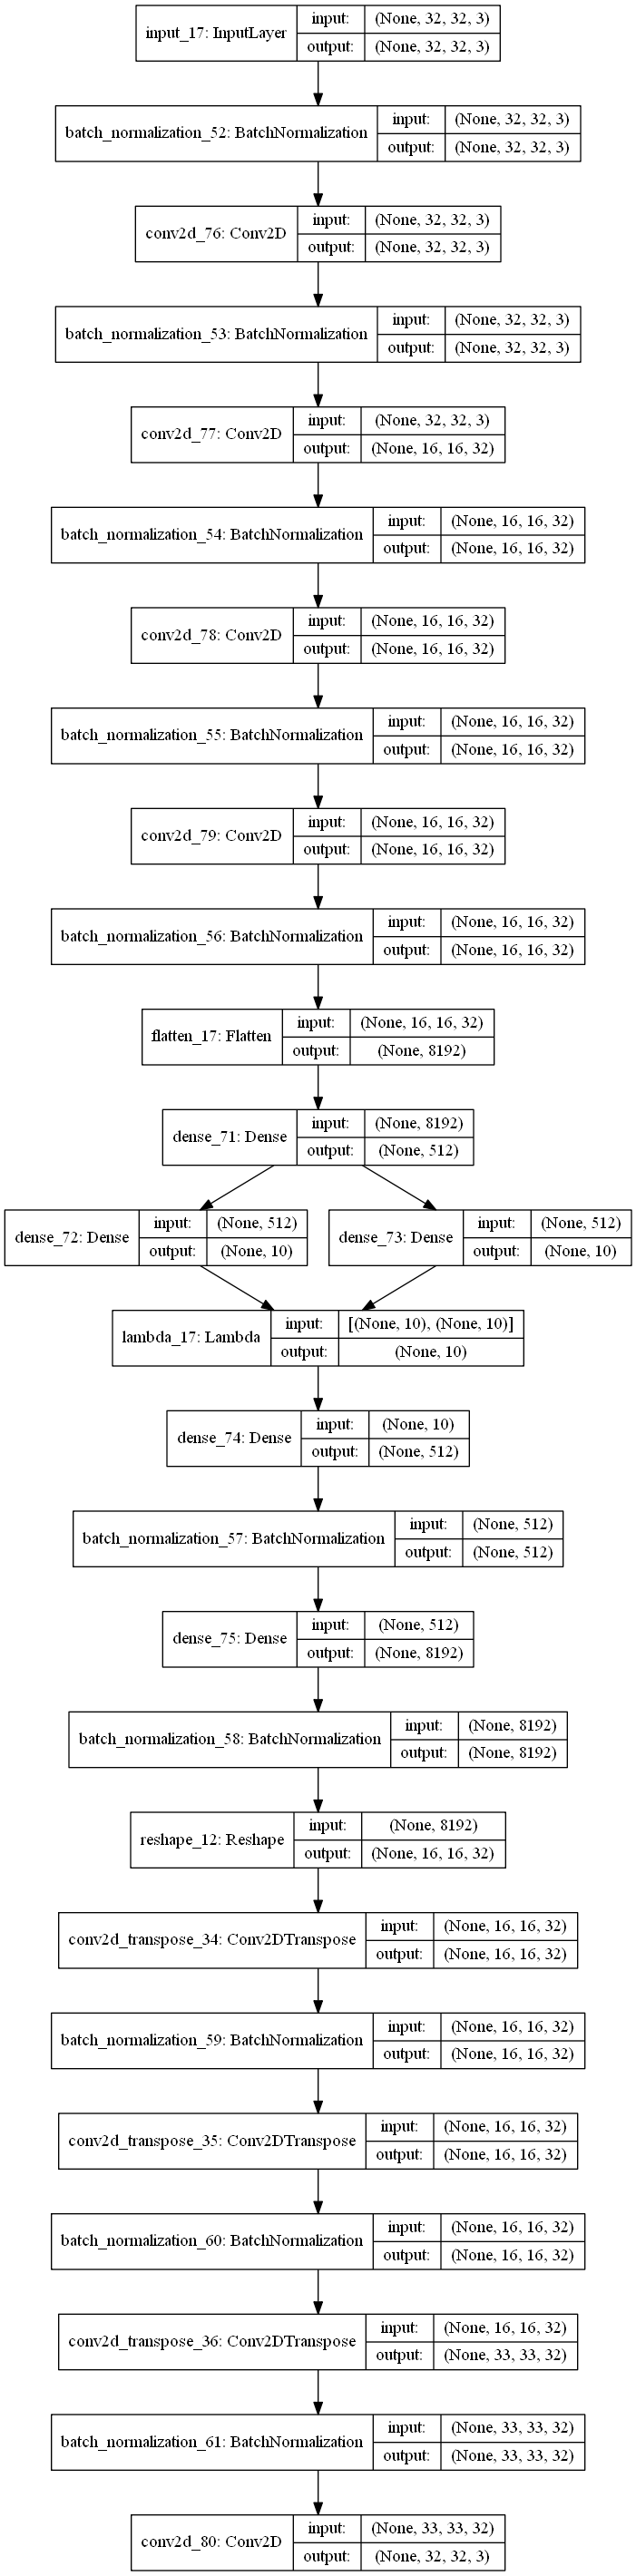

In [45]:
plot_model(var_autoencoder,show_shapes=True, to_file='./visualizations/batch_norm_vae.png')
Image(filename='./visualizations/batch_norm_vae.png')

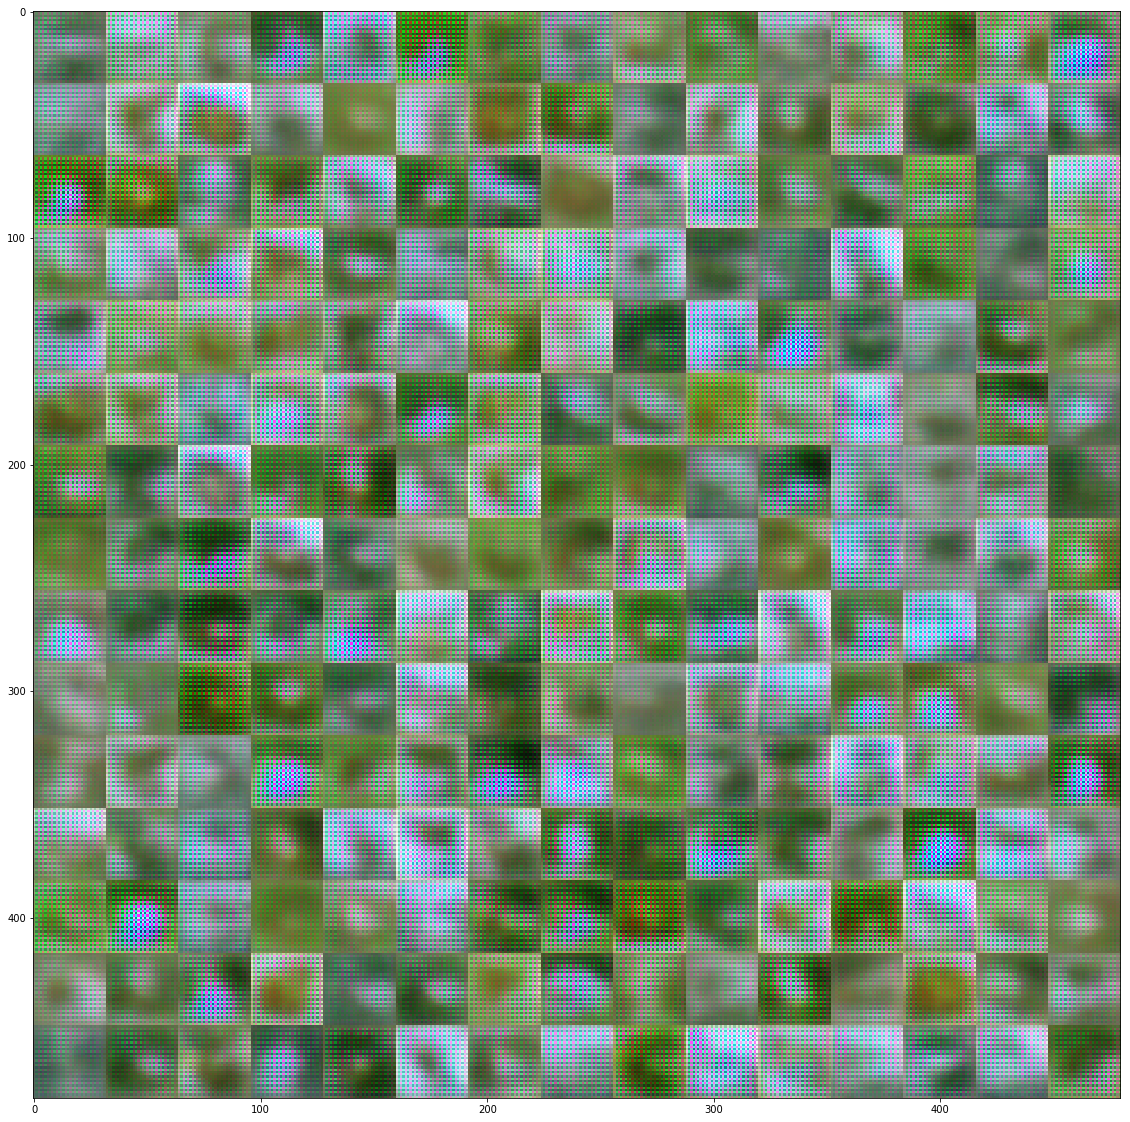

In [44]:
n = 15
figure = np.zeros((r * n, r * n, chnl))

for i in range(n):
    for j in range(n):
        sampled = np.array([np.random.uniform(-1,1 ,size=lat_space_dimension)])
        decoded = generator.predict(sampled)
        img = decoded[0].reshape(r, r, chnl)
        figure[i * r: (i + 1) * r,j * r: (j + 1) * r] = img
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

As we see here, applying batch normalization performed bad. The training and val losses were fluctuating by big margins every epoch.

Till now, Best generation is achieved in the Experiment 4 where epochs=100, latent dimension=10, intermediate dimension=512